[1.62109720e+10 1.38270891e+10 1.32270771e+10 1.29479906e+10
 1.28471077e+10 1.28006447e+10 1.27757024e+10 1.27637691e+10
 1.27527870e+10 1.27431507e+10]
(5000, 784)
[1.58626956e+10 1.36782006e+10 1.31545673e+10 1.29211524e+10
 1.28133950e+10 1.27684019e+10 1.27453447e+10 1.27327177e+10
 1.27246079e+10 1.27199790e+10]
(5000, 784)
[1.57941082e+10 1.39339969e+10 1.34292894e+10 1.31886351e+10
 1.30105874e+10 1.29222451e+10 1.28560755e+10 1.28109869e+10
 1.27667580e+10 1.27389464e+10]
(5000, 784)


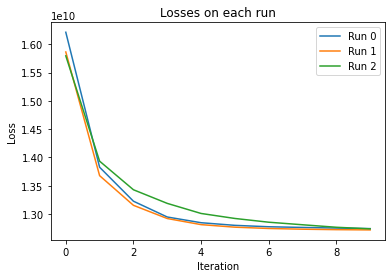

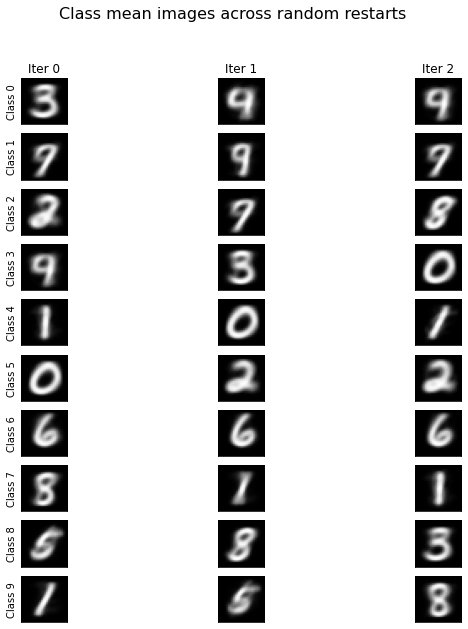

[3198185.6203506  2933310.26680352 2877922.7526047  2863557.87827883
 2857155.40753611 2850739.19085984 2841767.69023159 2834065.52910828
 2828174.1302162  2823331.76047509]
(5000, 784)
[3206435.98587324 2923623.27961977 2835638.70534409 2804877.23124426
 2791522.27394222 2783968.12822998 2778976.32615106 2775181.26749696
 2772289.75405612 2769602.90880494]
(5000, 784)
[3186202.28841889 2923265.29619058 2869033.95061055 2827974.02342636
 2809703.06330918 2800978.74684065 2794307.77002506 2788015.40148421
 2782547.69596132 2778048.38358795]
(5000, 784)


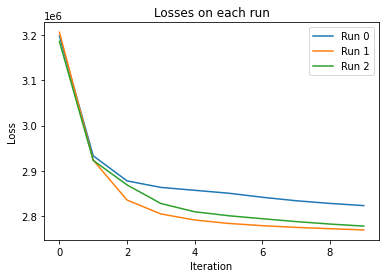

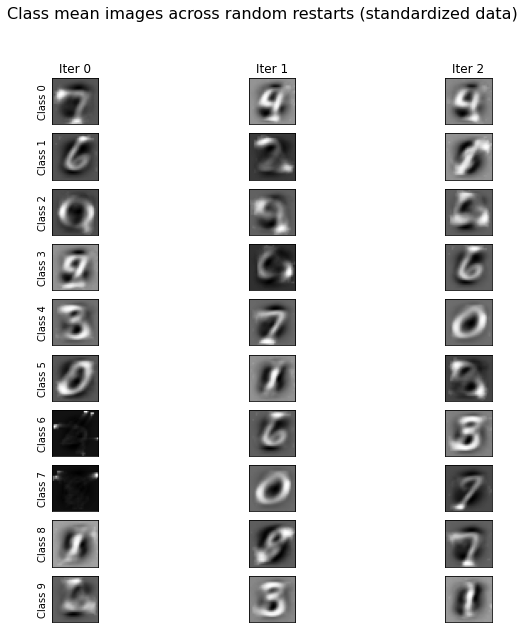

In [9]:
# CS 181, Spring 2022
# Homework 4

import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# Loading datasets for K-Means and HAC
small_dataset = np.load("data/small_dataset.npy")
large_dataset = np.load("data/large_dataset.npy")

np.random.seed(2)

# NOTE: You may need to add more helper functions to these classes
class KMeans(object):
    # K is the K in KMeans
    def __init__(self, K, runs):
        self.K = K
        self.means = None
        self.runs = runs
        self.assignment = None
        self.losses = np.zeros(runs)
        self.title = "KMeans"

    # X is a (N x 784) array since the dimension of each image is 28x28.
    def fit(self, X):
        # Initialize cluster assignment and random centers
        self.assignment = np.zeros(X.shape[0])
        self.means = np.random.randn(self.K, X.shape[1])

        for run in range(self.runs):
            # Assign datapoints to nearest cluster
            for i, x in enumerate(X):
                self.assignment[i] = np.argmin(np.linalg.norm(x - self.means, axis=1) ** 2)

            # Update cluster means
            for k in range(self.K):
                clusteroid = X[self.assignment == k]
                if clusteroid.size != 0:
                    self.means[k] = clusteroid.mean(axis=0)
            
            # Record loss
            self.losses[run] = self.__objective(X)
        return

    # This should return the arrays for K images. Each image should represent the mean of each of the fitted clusters.
    def get_mean_images(self):
        return self.means
    
    def get_losses(self):
        return self.losses

    def get_assignment(self):
        return self.assignment
    
    def __objective(self, X):
        return np.sum([np.linalg.norm(x - self.means[int(self.assignment[i])]) ** 2 for i, x in enumerate(X)])

class HAC(object):
    def __init__(self, linkage):
        self.linkage = linkage
        self.assignments = []
        self.X = None
        self.title = f"HAC with {linkage} linkage"
    
    # X is a (N x 784) array since the dimension of each image is 28x28.
    def fit(self, X):
        # Store X
        self.X = X

        # Create initial cluster assignment
        N = X.shape[0]
        assignment = np.arange(N)
        self.assignments.append(np.copy(assignment))

        # Perform clustering
        nclusters = N
        merged = set()
        while nclusters > 1:
            # Find nearest clusters
            midx, mval = [0, 1], float('inf')
            for i in range(N):
                for j in range(i+1, N):
                    if i in merged or j in merged:
                        continue

                    Xi, Xj = X[assignment == i], X[assignment == j]
                    m = 0
                    if self.linkage == 'centroid':
                        m = np.linalg.norm(Xi.mean(axis=0) - Xj.mean(axis=0))
                    elif self.linkage == 'min':
                        m = np.min(cdist(Xi, Xj))
                    else:
                        m = np.max(cdist(Xi, Xj))

                    if m < mval:
                        mval = m
                        midx = [i, j]

            # Merge clusters
            assignment[assignment == midx[1]] = midx[0]
            merged.add(midx[1])
            self.assignments.append(np.copy(assignment))
            nclusters -= 1

        return

    # Returns the mean image when using n_clusters clusters
    def get_mean_images(self, n_clusters):
        means = np.zeros((n_clusters, self.X.shape[1]))
        assignment = self.assignments[-n_clusters]
        clusters = np.unique(assignment)
        for i, cluster in enumerate(clusters):
            means[i] = self.X[assignment == cluster].mean(axis=0)
        return means

    def get_assignment(self, n_clusters=10):
        return self.assignments[-n_clusters]

# Plotting code for parts 2 and 3
def make_mean_image_plot(data, standardized=False):
    # Number of random restarts
    niters = 3
    runs = 10
    K = 10
    # Will eventually store the pixel representation of all the mean images across restarts
    allmeans = np.zeros((K, niters, 784))
    alllosses = np.zeros((K, runs))
    for i in range(niters):
        KMeansClassifier = KMeans(K=K, runs=runs)
        KMeansClassifier.fit(data)
        allmeans[:,i] = KMeansClassifier.get_mean_images()
        alllosses[:,i] = KMeansClassifier.get_losses()
    
    # Plot losses
    fig = plt.figure()
    for i in range(niters):
        plt.plot(alllosses[:,i], label=f'Run {i}')
        print(alllosses[:,i])
        print(large_dataset.shape)
    plt.title('Losses on each run')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    fig = plt.figure(figsize=(10,10))
    plt.suptitle('Class mean images across random restarts' + (' (standardized data)' if standardized else ''), fontsize=16)
    for k in range(K):
        for i in range(niters):
            ax = fig.add_subplot(K, niters, 1+niters*k+i)
            plt.setp(ax.get_xticklabels(), visible=False)
            plt.setp(ax.get_yticklabels(), visible=False)
            ax.tick_params(axis='both', which='both', length=0)
            if k == 0: plt.title('Iter '+str(i))
            if i == 0: ax.set_ylabel('Class '+str(k), rotation=90)
            plt.imshow(allmeans[k,i].reshape(28,28), cmap='Greys_r')
    plt.show()

# ~~ Part 2 ~~
make_mean_image_plot(large_dataset, False)

# ~~ Part 3 ~~
# Change this line! standardize large_dataset and store the result in large_dataset_standardized
std = np.std(large_dataset, axis=0)
std[std == 0] = 1
large_dataset_standardized = (large_dataset - large_dataset.mean(axis=0)) / std
make_mean_image_plot(large_dataset_standardized, True)

# # Plotting code for part 4
# LINKAGES = [ 'max', 'min', 'centroid' ]
# n_clusters = 10

# hacs = []

# fig = plt.figure(figsize=(10,10))
# plt.suptitle("HAC mean images with max, min, and centroid linkages")
# for l_idx, l in enumerate(LINKAGES):
#     # Fit HAC
#     hac = HAC(l)
#     hac.fit(small_dataset)
#     mean_images = hac.get_mean_images(n_clusters)
#     hacs.append(hac)
#     # Make plot
#     for m_idx in range(mean_images.shape[0]):
#         m = mean_images[m_idx]
#         ax = fig.add_subplot(n_clusters, len(LINKAGES), l_idx + m_idx*len(LINKAGES) + 1)
#         plt.setp(ax.get_xticklabels(), visible=False)
#         plt.setp(ax.get_yticklabels(), visible=False)
#         ax.tick_params(axis='both', which='both', length=0)
#         if m_idx == 0: plt.title(l)
#         if l_idx == 0: ax.set_ylabel('Class '+str(m_idx), rotation=90)
#         plt.imshow(m.reshape(28,28), cmap='Greys_r')
# plt.show()

In [2]:
# # Plot cluster sizes for each HAC linkage
# for hac in hacs:
#     _, counts = np.unique(hac.assignments[-n_clusters], return_counts=True)
#     fig = plt.figure()
#     plt.plot(counts, '.')
#     plt.title(f'HAC cluster counts with {hac.linkage} linkage')
#     plt.xlabel('Cluster index')
#     plt.ylabel('Number of images in cluster')
#     plt.show()

# Question 1

## Part 1.1

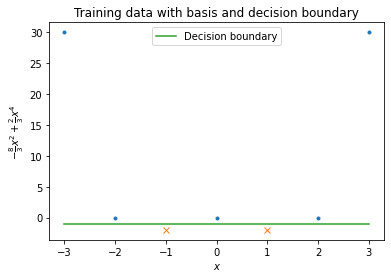

In [3]:
import numpy as np
import matplotlib.pyplot as plt

D = np.array([
    [-3, 1],
    [-2, 1],
    [-1, -1],
    [0, 1],
    [1, -1],
    [2, 1],
    [3, 1]
])
X, y = D[:,0], D[:,1]

def basis(X):
    Phi = np.zeros((X.size, 2))
    Phi[:,0] = np.copy(X)
    Phi[:,1] = (-8 / 3) * (X ** 2) + (2 / 3) * (X ** 4)
    return Phi

X = basis(X)
Xrange = np.arange(-3, 3, 0.1)

fig = plt.figure()
plt.plot(X[y == 1][:, 0], X[y == 1][:, 1], '.')
plt.plot(X[y == -1][:, 0], X[y == -1][:, 1], 'x')
plt.plot(np.array([-3, 3]), np.array([-1, -1]), label="Decision boundary")
plt.title('Training data with basis and decision boundary')
plt.xlabel(r'$x$')
plt.ylabel(r'$-\frac{8}{3} x^2 + \frac{2}{3} x^4$')
plt.savefig("1-1.png")
plt.legend()
plt.show()

## Part 1.7

In [4]:
D = np.array([
    [-2, 1],
    [-1, -1],
    [0, 1],
    [1, -1],
    [2, 1]
])
X, y = D[:,0], D[:,1]

w, w0 = np.array([[0],[1]]), 1

def basis(x):
    return np.array([x, (-8 / 3) * (x ** 2) + (2 / 3) * (x ** 4)])

def equality(x, y):
    return (y * (np.dot(w.T, basis(x)) + w0)) == 1

np.all([equality(X[i], y[i]) for i in range(y.size)])

True

## Part 1.8

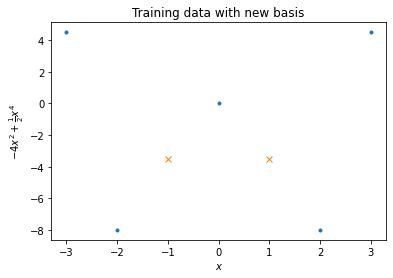

In [5]:
D = np.array([
    [-3, 1],
    [-2, 1],
    [-1, -1],
    [0, 1],
    [1, -1],
    [2, 1],
    [3, 1]
])
X, y = D[:,0], D[:,1]

def basis(X):
    Phi = np.zeros((X.size, 2))
    Phi[:,0] = np.copy(X)
    Phi[:,1] = -4 * (X ** 2) + (1 / 2) * (X ** 4)
    return Phi

X = basis(X)
Xrange = np.arange(-3, 3, 0.1)

fig = plt.figure()
plt.plot(X[y == 1][:, 0], X[y == 1][:, 1], '.')
plt.plot(X[y == -1][:, 0], X[y == -1][:, 1], 'x')
plt.title('Training data with new basis')
plt.xlabel(r'$x$')
plt.ylabel(r'$-4 x^2 + \frac{1}{2} x^4$')
plt.savefig("1-8.png")
plt.show()

In [6]:
# 